In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
from tqdm import tqdm
import re
import random
import pickle
from pathlib import Path
from typing import Any, Union
import os
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from tqdm import trange
from operator import itemgetter


# Example usage:
from invasion import (
    compute_nontrivial_slice,
    simulate_segment,
    compute_deltaW_curve,
    compare_severities,
    test_plot,
    compare_scalers,
    run_cycles,
    run_cycles_ext,
    simulate_segment2,
    run_invasion,
    pairwise_invasion_plot,
    piplot,
    local_invasibility_heatmap,
    local_invasibility_path,
    test_invasion,
    local_invasibility2
)

W_birth = 0.4
W_death = 0.1
Y_birth = 0.9
Y_death = 0.15

X_in = 0.1
X_out = 0.1
Z_in = 0.5
Z_out = 0.25

Time = 600.0
dt = 0.01

use_X = True
use_Z = False

num_points = 100
severity = 0.8
cycles = 5000
extinction_rate = 50
U_out = 0.21
U_in = 0.26
X_out = 0.26
X_in = 0.11

W,Y = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
W0 = W/2
X0 = W0 / (X_out / X_in)
V0 = W - W0
U0 = V0 / (U_out / U_in)
Y0 = Y
Z0 = Y0/ (Z_out /Z_in)
dt = 0.1

In [2]:
def local_invasibility_path(
    V0, W0, Y0, 
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=5,
    U_in_min=0.01, U_in_max=0.4,
    U_out_min=0.01, U_out_max=0.4,
    folder='total_invasibility',
):
    """
    For each interior gridpoint (i,j) on [0,1]^2 in U_in, X_in:
      • Evaluate run_invasion at its 8 nearest neighbors
      • Compute mean of their np.sign(deltaW)
      • Plot that in grayscale (1=black…+1=white)
    """

    # 1) Prepare output directory
    os.makedirs(folder, exist_ok=True)

    # 2) Build the [0,1] grid
    U_in_vals = np.linspace(U_in_min, U_in_max, grid_size)
    U_out_vals = np.linspace(U_out_min, U_out_max, grid_size)

    # 3) Initialize the score matrix
    score = np.zeros((grid_size, grid_size))

    # 4) Offsets for the eight neighbors
    neighbor_offsets = [         (1,0),       
                        ( 0,1),         ( 0,-1),
                                 ( -1,0),       ]
    deltas = {}

    steps = 0

    current = (1, 1)
    path_coords = []


    while steps < grid_size:
        steps += 1
        i, j = current
        path_coords.append((U_in_vals[i], U_out_vals[j]))
        shuffeled_offsets = neighbor_offsets.copy()
        random.shuffle(shuffeled_offsets)
        for di, dj in shuffeled_offsets:
                X_in = U_in_vals[i+di]
                X_out = U_out_vals[j+dj]

                if ((i+di,j+dj), (i,j)) in deltas.keys():
                    if deltas[((i+di,j+dj), (i,j))] == 0:
        
                        current = (di, dj)
                        continue
                    else:
                        continue   
                else:
                    deltaW = run_invasion(

                         V0=V0, W0=W0, Y0=Y0,
                        W_birth=W_birth, Y_birth=Y_birth,
                        W_death=W_death, Y_death=Y_death,
                        X_in=X_in, X_out=X_out,
                        U_in=U_in_vals[i],U_out=U_in_vals[j],
                        Z_in=Z_in, Z_out=Z_out,
                        extinction_rate=extinction_rate, dt=dt,
                        use_X=use_X, use_Z=use_Z,
                        cycles=cycles, severity=severity,
                        perturb_W=False, perturb_Y=True,
                        plot=False,

    
                    )
                    if deltaW> 0:
                        deltas[((i,j), (i+di,j+dj))] = 1
                        deltas[((i+di,j+dj), (i,j))] = 0
                        current = (di, dj)
                        continue
                    else:
                        deltas[((i,j), (i+di,j+dj))] = 0
                        deltas[((i+di,j+dj), (i,j))] = 1
                       

    return U_in_vals, U_out_vals, deltas, path_coords




In [ ]:
b = local_invasibility_path(
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=50,
    U_in_min  = 0.01,
    U_in_max  = 0.5, 
    U_out_min  = 0.01, 
    U_out_max  = 0.5

)

(array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 {((1, 1), (0, 1)): 0,
  ((0, 1), (1, 1)): 1,
  ((1, 1), (1, 0)): 1,
  ((1, 0), (1, 1)): 0,
  ((1, 1), (1, 2)): 0,
  ((1, 2), (1, 1)): 1,
  ((1, 1), (2, 1)): 1,
  ((2, 1), (1, 1)): 0,
  ((1, 0), (1, -1)): 0,
  ((1, -1), (1, 0)): 1,
  ((1, 0), (2, 0)): 1,
  ((2, 0), (1, 0)): 0,
  ((1, 0), (0, 0)): 0,
  ((0, 0), (1, 

Computing local invasibility: 100%|██████████| 18/18 [02:34<00:00,  8.56s/it]


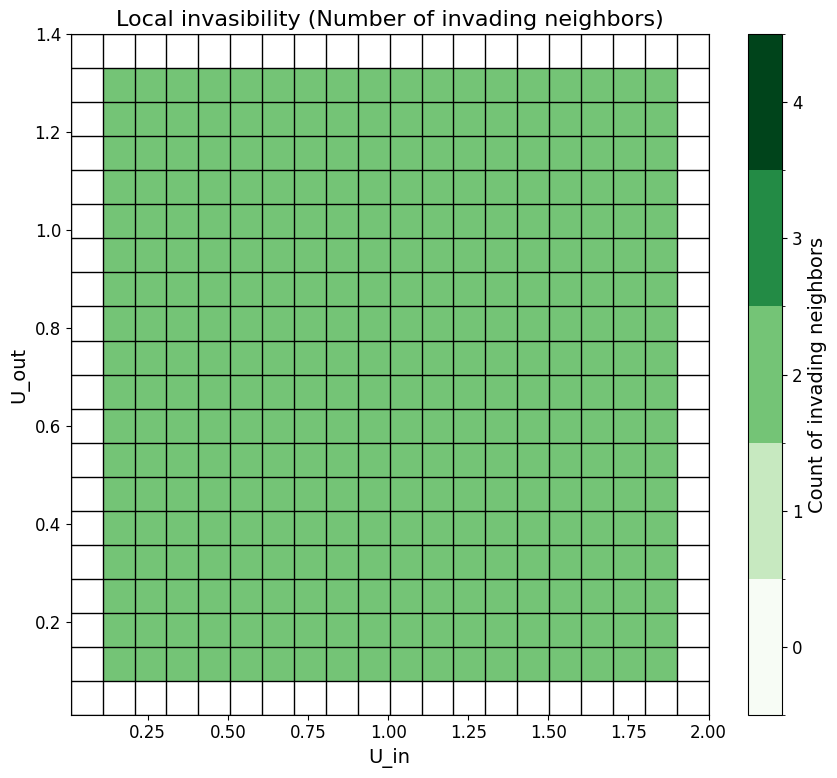

In [34]:
x = local_invasibility_heatmap(
    V0 = V0, W0=W0, Y0=Y0,
    W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
    Z_in=Z_in, Z_out=Z_out,
    extinction_rate=extinction_rate, dt=dt,
    use_X=use_X, use_Z=use_Z,
    cycles=cycles, severity=severity,
    grid_size=20,
    U_in_min  = 0.01,
    U_in_max  = 2, 
    U_out_min  = 0.01, 
    U_out_max  = 1.4,
    break_threshold=0.001,
    perturb_Y = False,
    perturb_W= True
)



In [9]:
score = local_invasibility2(
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=10,
    U_in_min  = 0.01,
    U_in_max  = 10, 
    U_out_min  = 0.01, 
    U_out_max  = 0.4

)

Computing local invasibility: 100%|██████████| 8/8 [10:58<00:00, 82.33s/it] 


In [4]:
score = score.T

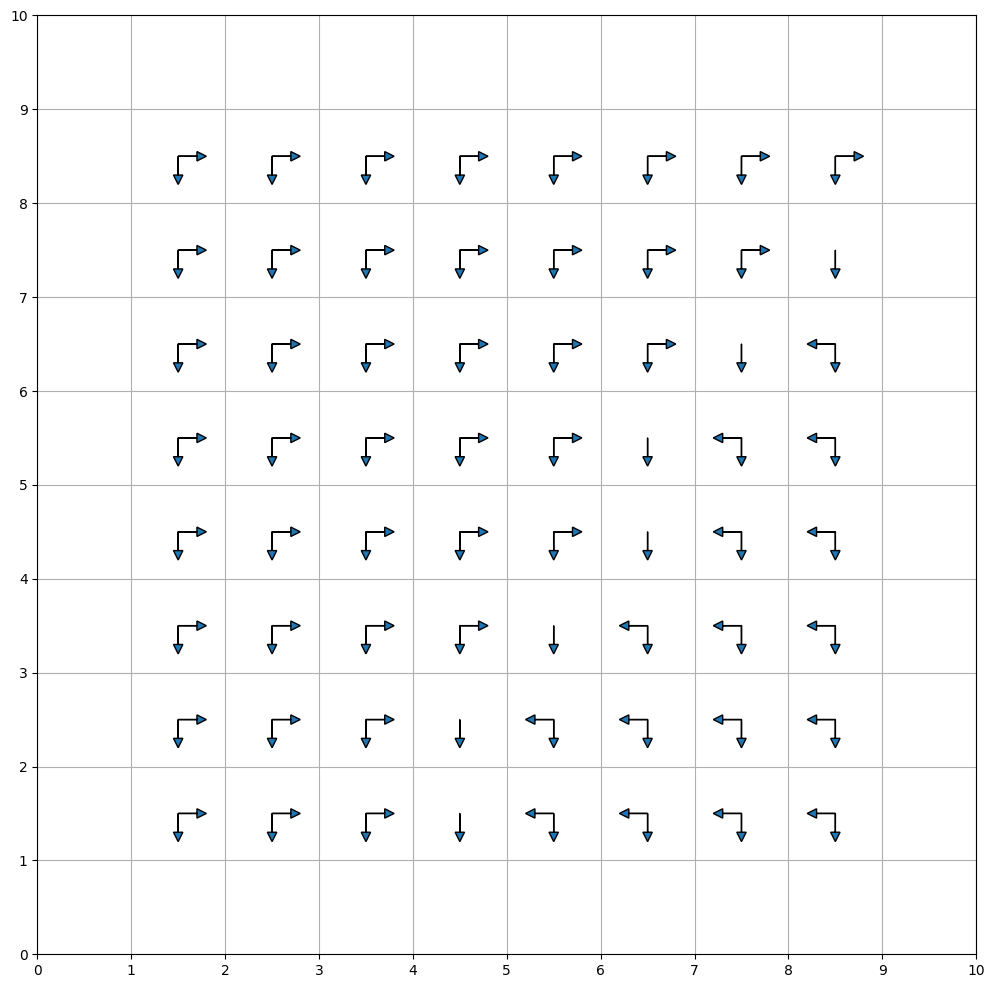

In [5]:
def plot_arrow_grid(score, arrow_scale=0.3, save=False, folder="arrow_grid", filename="arrow_grid.pdf"):
    """
    Visualizes a grid of directional arrows for each cell.
    
    Parameters:
        score: 2D numpy array of shape (N,N), with each entry a numpy array of 4 integers (0 or 1).
        arrow_scale: float, length of each arrow.
        save: if True, saves the plot as PDF.
        folder: folder to save the plot.
        filename: filename of the PDF.
    """
    nrows, ncols = score.shape
    fig, ax = plt.subplots(figsize=(ncols, nrows))

    # Base grid
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(ncols+1))
    ax.set_yticks(np.arange(nrows+1))
    ax.grid(True)

    # Draw arrows
    for i in range(nrows):
        for j in range(ncols):
            directions = score[i, j]
            x, y = j + 0.5, i + 0.5  # center of cell

            if directions[0]:  # up
                ax.arrow(x, y, 0, arrow_scale, head_width=0.1, head_length=0.1, length_includes_head=True)
            if directions[1]:  # down
                ax.arrow(x, y, 0, -arrow_scale, head_width=0.1, head_length=0.1, length_includes_head=True)
            if directions[2]:  # right
                ax.arrow(x, y, arrow_scale, 0, head_width=0.1, head_length=0.1, length_includes_head=True)
            if directions[3]:  # left
                ax.arrow(x, y, -arrow_scale, 0, head_width=0.1, head_length=0.1, length_includes_head=True)
            

    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    plt.tight_layout()

    if save:
        os.makedirs(folder, exist_ok=True)
        path = os.path.join(folder, filename)
        plt.savefig(path, format='pdf')

    plt.show()

plot_arrow_grid(score)

In [6]:
with open('helper.pkl', 'rb') as handle:
    helper = pickle.load(handle)


In [ ]:
def save_dict_as_pickle(
    d: dict,
    filename: str,
    protocol: int = pickle.HIGHEST_PROTOCOL
) -> None:
    """
    Serialize the dictionary `d` to a pickle file at `filename`.

    Parameters
    ----------
    d : dict
        Dictionary to serialize.
    filename : str
        Destination file path (e.g. 'helper.pkl').
    protocol : int, optional
        Pickle protocol to use (defaults to HIGHEST_PROTOCOL).
    """
    target = Path(filename)
    with target.open("wb") as f:
        pickle.dump(d, f, protocol=protocol)
    print(f"Dictionary successfully saved to '{filename}'.")

# %% 
# 2) Save the `helper` dict
save_dict_as_pickle(helper, "helper.pkl")

# %% 
def load_pickle_file(path: Union[Path, str]) -> Any:
    """
    Load and return the Python object stored in a pickle file.

    Parameters
    ----------
    path : pathlib.Path or str
        Path to the pickle file to load.

    Returns
    -------
    object
        The deserialized Python object.

    Raises
    ------
    FileNotFoundError
        If the specified file does not exist.
    pickle.UnpicklingError
        If the file is not a valid pickle or is corrupted.
    """
    file_path = Path(path)
    if not file_path.is_file():
        raise FileNotFoundError(f"Pickle file not found: {file_path!r}")

    with file_path.open("rb") as f:
        try:
            obj = pickle.load(f)
        except pickle.UnpicklingError as e:
            raise pickle.UnpicklingError(
                f"Failed to unpickle file {file_path!r}: {e}"
            )
    return obj

# %% 
# 3) Load and verify
loaded_helper = load_pickle_file("helper.pkl")
print("\nReloaded object type:", type(loaded_helper).__name__)
print("Number of entries:", len(loaded_helper))

# Verify integrity
assert loaded_helper == helper, "Loaded dictionary does not match the original!"
print("Integrity check passed: loaded dictionary is identical to the original.")

Dictionary successfully saved to 'helper.pkl'.

Reloaded object type: dict
Number of entries: 24648
Integrity check passed: loaded dictionary is identical to the original.


In [32]:
plt.rcParams.update({
    'font.size': 14,             # Base font size
    'axes.titlesize': 16,        # Title font size
    'axes.labelsize': 14,        # x and y label size
    'xtick.labelsize': 12,       # Tick label size (x)
    'ytick.labelsize': 12,       # Tick label size (y)
    'legend.fontsize': 12,       # Legend font size
    'figure.titlesize': 18       # Figure-wide title size (if used)
})

def reconstruct_and_flow_map(
    signs,
    x_vals,
    y_vals,
    folder='surface_flow',
    arrow_scale=20,
    invert=False
):
    """
    Reconstruct the scalar field f from sign data on a custom grid,
    compute its gradient, plot a quiver (flow) map of the gradient vectors
    with adjustable arrow length, and overlay markers at every tested data point.

    Parameters
    ----------
    signs : dict
        Mapping edge tuples ((i,j),(ii,jj)) to sign values (+1 or -1).
        Indices i in [0, len(x_vals)), j in [0, len(y_vals)).
    x_vals : Sequence[float]
        1D array of x-coordinates (length Nx).
    y_vals : Sequence[float]
        1D array of y-coordinates (length Ny).
    folder : str
        Directory to save the PDF of the flow map.
    arrow_scale : float
        Controls arrow length (smaller → longer).
    invert : bool
        If True, flip arrow directions (for sign convention).

    Returns
    -------
    predicted_signs : dict
        Dictionary mapping edge tuples to predicted signs from the reconstructed field.
    """
    os.makedirs(folder, exist_ok=True)
    Nx = len(x_vals)
    Ny = len(y_vals)
    M = Nx * Ny
    idx = lambda i, j: i * Ny + j

    # Build sparse Laplacian and RHS g
    rows, cols, data = [], [], []
    g = np.zeros(M)
    offsets = [(1,0), (-1,0), (0,1), (0,-1)]

    for i in trange(Nx, desc='Building Laplacian'):
        for j in range(Ny):
            n = idx(i, j)
            deg = 0
            for di, dj in offsets:
                ii, jj = i + di, j + dj
                if 0 <= ii < Nx and 0 <= jj < Ny:
                    deg += 1
                    rows.append(n); cols.append(idx(ii, jj)); data.append(-1)
                    g[n] += signs.get(((i, j), (ii, jj)), 0)
            rows.append(n); cols.append(n); data.append(deg)

    L = sp.coo_matrix((data, (rows, cols)), shape=(M, M)).tocsr()
    L[0, :] = 0; L[0, 0] = 1; g[0] = 0

    # Solve for f
    f_vec = spla.spsolve(L, g)
    f = f_vec.reshape((Nx, Ny))

    # Compute gradient with non-uniform spacing
    fx, fy = np.gradient(f, x_vals, y_vals, edge_order=2)

    # Create meshgrid for plotting
    X, Y = np.meshgrid(x_vals, y_vals, indexing='ij')

    # Normalize vectors and optionally invert
    speed = np.hypot(fx, fy)
    fx_n = fx / (speed + 1e-8)
    fy_n = fy / (speed + 1e-8)
    if invert:
        fx_n, fy_n = -fx_n, -fy_n

    # Mask borders
    fx_n_masked = fx_n.copy()
    fy_n_masked = fy_n.copy()
    speed_masked = speed.copy()

    fx_n_masked[0, :] = 0
    fx_n_masked[-1, :] = 0
    fx_n_masked[:, 0] = 0
    fx_n_masked[:, -1] = 0

    fy_n_masked[0, :] = 0
    fy_n_masked[-1, :] = 0
    fy_n_masked[:, 0] = 0
    fy_n_masked[:, -1] = 0

    speed_masked[0, :] = 0
    speed_masked[-1, :] = 0
    speed_masked[:, 0] = 0
    speed_masked[:, -1] = 0

    # Collect every tested data point (nodes)
    tested_nodes = set()
    for (i_j, ii_jj) in signs.keys():
        i, j = i_j
        ii, jj = ii_jj
        if 0 <= i < Nx and 0 <= j < Ny:
            tested_nodes.add((i, j))
        if 0 <= ii < Nx and 0 <= jj < Ny:
            tested_nodes.add((ii, jj))

    tested_x = [x_vals[i] for (i, _) in tested_nodes]
    tested_y = [y_vals[j] for (_, j) in tested_nodes]

    # Plot quiver + tested data points
    fig, ax = plt.subplots(figsize=(10, 7))
    q = ax.quiver(
        X, Y, fx_n_masked, fy_n_masked,
        speed_masked,
        scale=arrow_scale,
        cmap='inferno',
        pivot='mid'
    )

    ax.set_xlabel('α W')
    ax.set_ylabel('α X')
    ax.set_title('Local Invasibility')
    ax.legend()
    plt.tight_layout()

    # Save PDF
    pdf_path = os.path.join(folder, 'flow_map_tested_points.pdf')
    fig.savefig(pdf_path, format='pdf')
    plt.show()
    print(f"Saved flow map with tested data points to {pdf_path}")

    # Predict signs from reconstructed f
    predicted_signs = {}
    for ((i, j), (ii, jj)), true_sign in signs.items():
        if 0 <= i < Nx and 0 <= j < Ny and 0 <= ii < Nx and 0 <= jj < Ny:
            df = -f[ii, jj] + f[i, j] if invert else f[ii, jj] - f[i, j]
            sign = np.sign(df)
            if sign != 0:
                predicted_signs[((i, j), (ii, jj))] = int(sign)

    return predicted_signs

Building Laplacian: 100%|██████████| 20/20 [00:00<00:00, 4122.77it/s]
/Users/xaverwangerpohl/anaconda3/envs/dreiAcht/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


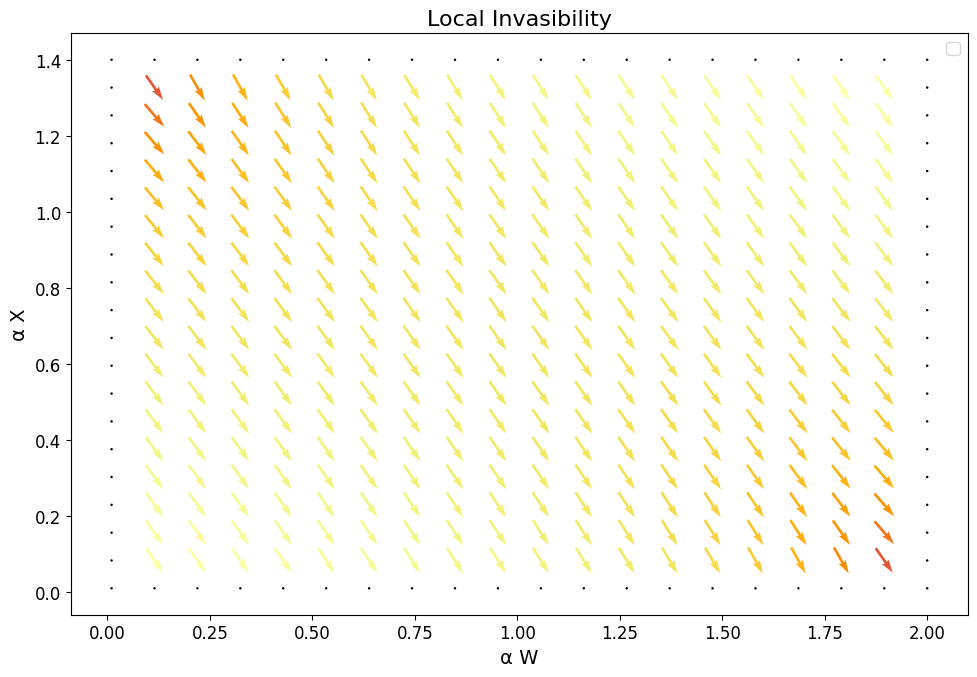

Saved flow map with tested data points to surface/flow_map_tested_points.pdf


In [35]:
preds = reconstruct_and_flow_map(
    x[3], x_vals=x[0], y_vals=x[1], folder='surface', arrow_scale=30, invert=True
)

In [44]:
violations = {
    k: (preds.get(k), v)
    for k, v in x[3].items()
    if preds.get(k, 0) != v
}
violations

{((28, 1), (29, 1)): (1, -1), ((29, 1), (28, 1)): (-1, 1)}

In [20]:
len(preds)

288

In [48]:

i0, j0 = 6, 1  # example source indices

sub_deltas = {
    (k, l): v
    for ((i, j), (k, l)), v in x[3].items()
    if (i == i0 and j == j0)
}
sub_deltas

{(5, 1): -1, (6, 0): 1, (6, 2): -1, (7, 1): -1}

In [36]:
def test_invasion(
    U_in_vals, U_out_vals, deltas, test_point,
    V0, W0, Y0, 
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity, break_threshold
):
    
    sub_deltas = {
    (k, l): v
    for ((i, j), (k, l)), v in x[3].items() 
    if (i == test_point[0] and j == test_point[1])}
    print(sub_deltas)
    X_vals = [
    (U_in_vals[k], U_out_vals[l])
    for ((i, j), (k, l)), v in deltas.items()
    if (i == test_point[0] and j == test_point[1])
    ]
    print(X_vals)
    
    X_vals = sorted(X_vals, key=itemgetter(0, 1))
    
    U_vals = [
    U_in_vals[test_point[0]], U_out_vals[test_point[1]]]

    U_in, U_out = U_vals

    for Xs in X_vals:
        X_in, X_out = Xs

        args = {
                    "V0": V0, "W0": W0, "Y0": Y0,
                    "W_birth": W_birth, "Y_birth": Y_birth,
                    "W_death": W_death, "Y_death": Y_death,
                    "X_in": X_in, "X_out": X_out,
                    "U_in": U_in, "U_out": U_out,
                    "Z_in": Z_in, "Z_out": Z_out,
                    "extinction_rate": extinction_rate, "dt": dt,
                    "use_X": use_X, "use_Z": use_Z,
                    "cycles": cycles, "severity": severity,
                    "perturb_W": False, "perturb_Y": True,
                    "plot": False, "break_threshold": break_threshold
                    }
        
        a = run_invasion(
            V0, W0, Y0,
            W_birth, Y_birth,
            W_death, Y_death,
            X_in, X_out,
            U_in, U_out,
            Z_in, Z_out,
            extinction_rate, dt,
            use_X, use_Z,
            severity,
            cycles=cycles,
            perturb_W=False,
            perturb_Y=True,
            plot=True, break_threshold=break_threshold
        )
        print(a)
  
    return X_vals, U_vals



In [7]:
deltas2 = {
    (k-i0, l-j0): v
    for (k, l), v in sub_deltas.items()
}
deltas2

{(-1, 0): 1, (0, -1): 1, (0, 1): -1, (1, 0): -1}

{(5, 1): -1, (6, 0): 1, (6, 2): -1, (7, 1): -1}
[(0.1711111111111111, 0.03111111111111111), (0.20333333333333334, 0.01), (0.20333333333333334, 0.052222222222222225), (0.23555555555555557, 0.03111111111111111)]
Saved run_invasion plot to run_invasion/run_invasion165.pdf


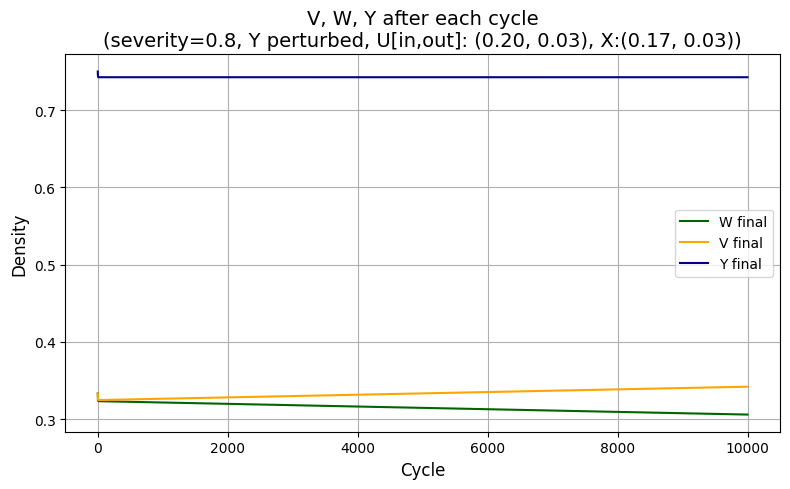

-0.017273041948678958
Saved run_invasion plot to run_invasion/run_invasion166.pdf


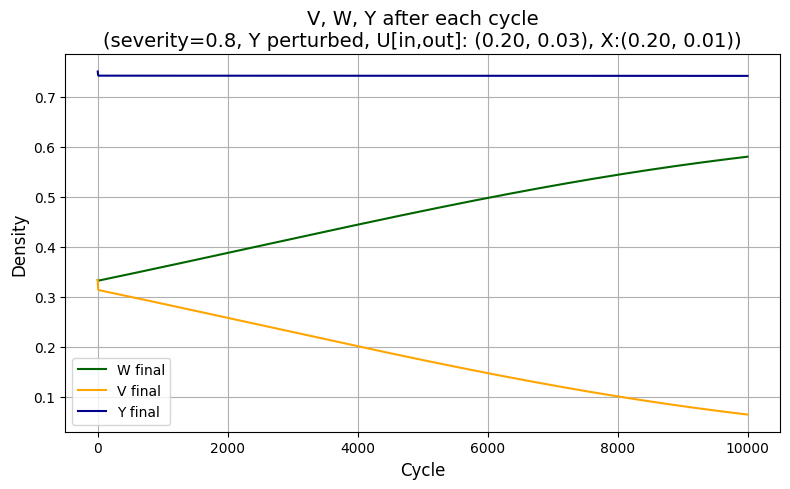

0.2465316636117219
Saved run_invasion plot to run_invasion/run_invasion167.pdf


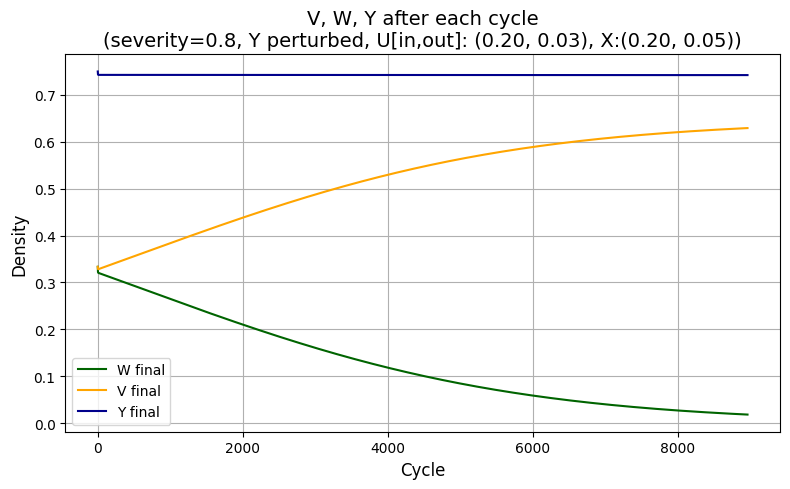

-0.3000050641129298
Saved run_invasion plot to run_invasion/run_invasion168.pdf


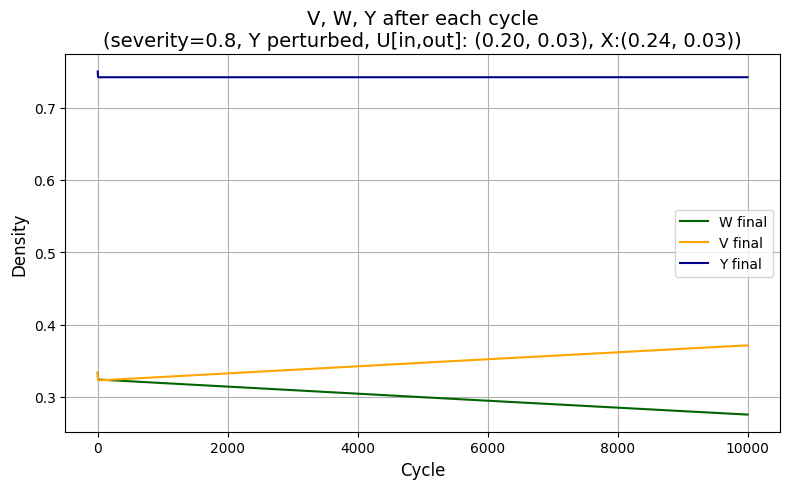

-0.04821118122875517


([(0.1711111111111111, 0.03111111111111111),
  (0.20333333333333334, 0.01),
  (0.20333333333333334, 0.052222222222222225),
  (0.23555555555555557, 0.03111111111111111)],
 [0.20333333333333334, 0.03111111111111111])

In [50]:
cycles = 10000
test_invasion(
    x[0], x[1], x[3], (i0, j0),
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity, break_threshold=.3 
)

In [23]:
neighbour_dict = {
        (0,1) :np.array((1,0,0,0)),
        (0,-1):np.array((0,1,0,0)),
        (1,0) :np.array((0,0,1,0)),
        (-1,0):np.array((0,0,0,1))
    } 
for (di,dj), v in neighbour_dict.items():
                print((di,dj))
                print(v)

(0, 1)
[1 0 0 0]
(0, -1)
[0 1 0 0]
(1, 0)
[0 0 1 0]
(-1, 0)
[0 0 0 1]
